In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astroNN.apogee import allstar, apogee_astronn

allstar_f = fits.getdata(allstar(dr=17))
nn_f = fits.getdata(apogee_astronn(dr=17))
age_f = pd.read_csv("./nn_latent_age_dr17.csv.gz")

good_idx = (~np.isnan(age_f["Age"])
            & (age_f["STARFLAG"]==0)
            & (age_f["ASPCAPFLAG"]==0)
            & (age_f["Age_Error"] / age_f["Age"] < 0.4)
            & ~np.isnan(nn_f["galr"])
            & ~np.isnan(nn_f["galz"]))

allstar_f = allstar_f[good_idx]
nn_f = nn_f[good_idx]

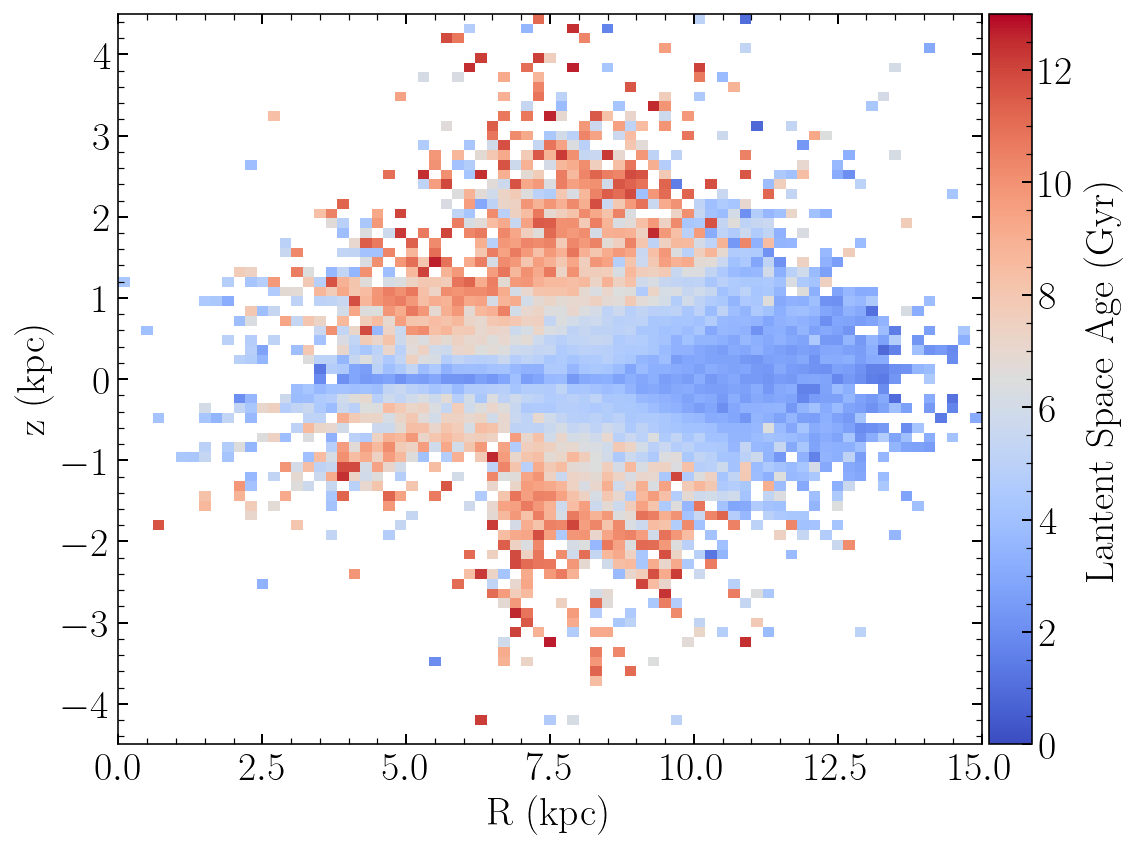

In [2]:
import numpy as np
import pylab as plt
from scipy.stats import binned_statistic_2d
from astroNN.shared import pylab_style
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

pylab_style(paper=True)

stat, xe, ye, binnumber = binned_statistic_2d(nn_f["galr"], 
                                              nn_f["galz"], 
                                              age_f["Age"][good_idx], 
                                              range=((0, 15), (-4.5, 4.5)), 
                                              bins=(75, 75),
                                              statistic=np.nanmedian)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
mappable = ax.pcolormesh(xe, ye, stat.T, cmap="coolwarm", vmin=0, vmax=13, rasterized=True)
ax.set_xlim(0, 15)
ax.set_ylim(-4.5, 4.5)
ax.set_xlabel("R (kpc)")
ax.set_ylabel("z (kpc)")

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Lantent Space Age (Gyr)")
fig.tight_layout()
fig.savefig("./figs/age_z_dist.pdf")